# LV 4: Word Embeddings i Semantička Sličnost

---

## 1. Uvod u Word Embeddings

Word embeddings predstavljaju tehniku prikaza riječi u numeričkom obliku ("vektori riječi") gdje su slične riječi (po značenju) smještene blizu u vektorskom prostoru. Umjesto rada s pojedinačnim riječima, tekstualne podatke modeliramo kao skup vektora koji dobro zadržavaju semantičke odnose. Time omogućujemo računalima napredno razumijevanje značenja riječi, pa se embeddingi koriste u zadacima poput prepoznavanja sinonima, pronalaženja antonima, mjerenja sličnosti rečenica i mnogim naprednim aplikacijama obrade jezika.

### Najčešće korištene tehnike:
- **Word2Vec**: model treniran na temelju konteksta riječi (CBOW i Skip-gram)
- **GloVe** (Global Vectors): kombinira globalnu statistiku i lokalni kontekst
- **FastText**: proširenje Word2Veca koje uključuje podriječi

### Korištenjem pretreniranih modela embeddinga možemo:
- Lako pronaći slične i suprotne riječi
- Vizualizirati prostorne odnose između pojmova (PCA, t-SNE)
- Mjeriti sličnost između rečenica ili dokumenata
- Koristiti embeddinge kao ulazne podatke za napredne NLP modele

Nakon ove vježbe studenti će moći raditi s embeddingima, razumjeti kako oni predstavljaju značenje riječi te koristiti embeddinge za analizu sličnosti i semantičkih odnosa u tekstu.

---



## 2. Korištene biblioteke

U ovoj vježbi koristimo:

**gensim**  
Biblioteka za rad s word embeddingima, uključuje:
- Učitavanje pretreniranih Word2Vec i GloVe modela
- Računanje semantičke sličnosti
- Operacije s vektorima riječi

**scikit-learn**  
Za smanjenje dimenzionalnosti i vizualizaciju (PCA, t-SNE).

**matplotlib**  
Za crtanje grafova i vizualizacija embedding prostora.

**numpy**  
Za matematičke operacije s vektorima.

---


In [1]:
!pip install -q gensim numpy matplotlib scikit-learn


[notice] A new release of pip is available: 25.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import gensim.downloader as api
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## 3. Inicijalizacija okruženja i učitavanje modela

---

### Primjer: Učitavanje pretreniranog Word2Vec modela

Gensim biblioteka omogućuje jednostavno preuzimanje različitih pretreniranih modela. U ovom primjeru koristimo **glove-wiki-gigaword-50**, manji model (50 dimenzija) pogodan za brzo testiranje.

Možete koristiti i veće modele poput:
- `glove-wiki-gigaword-100`
- `glove-wiki-gigaword-200`
- `word2vec-google-news-300` (vrlo velik, potrebno više vremena)


In [ ]:
print("Učitavanje modela...")
model = api.load("glove-wiki-gigaword-50")
print("Model uspješno učitan!")

print(f"Broj riječi u modelu: {len(model)}")

Učitavanje modela...
Model uspješno učitan!
Broj riječi u modelu: 400000


---

### Primjer: Prikaz vektora riječi

Svaka riječ u modelu ima svoj vektor (niz brojeva). Duljina vektora ovisi o modelu – ovdje je 50 dimenzija.

Demonstracija kako izgleda embedding za riječ "king".


In [4]:
vector_king = model['king']

print(f"Vektor za riječ 'king' (prvih 10 vrijednosti):")
print(vector_king[:10])

print(f"\nDuljina vektora: {len(vector_king)}")
print(f"Tip podatka: {type(vector_king)}")


Vektor za riječ 'king' (prvih 10 vrijednosti):
[ 0.50451   0.68607  -0.59517  -0.022801  0.60046  -0.13498  -0.08813
  0.47377  -0.61798  -0.31012 ]

Duljina vektora: 50
Tip podatka: <class 'numpy.ndarray'>


---

### Primjer: Računanje sličnosti između dviju riječi

Embeddings omogućuju mjerenje semantičke sličnosti. Model računa **kosinusnu sličnost** između vektora dviju riječi. Vrijednost je između 0 (potpuno različite) i 1 (identične).


In [5]:

similarity = model.similarity('king', 'queen')
print(f"Sličnost između 'king' i 'queen': {similarity:.4f}")

similarity2 = model.similarity('king', 'apple')
print(f"Sličnost između 'king' i 'apple': {similarity2:.4f}")

similarity3 = model.similarity('computer', 'laptop')
print(f"Sličnost između 'computer' i 'laptop': {similarity3:.4f}")


Sličnost između 'king' i 'queen': 0.7839
Sličnost između 'king' i 'apple': 0.3047
Sličnost između 'computer' i 'laptop': 0.7741


---

### Primjer: Pronalaženje sličnih riječi

Možemo pronaći riječi koje su najbliže (najsličnije) odabranoj riječi, korisno za traženje sinonima.


In [6]:

similar_words = model.most_similar('king', topn=5)

print("5 najsličnijih riječi za 'king':")
for word, score in similar_words:
    print(f"  {word}: {score:.4f}")


5 najsličnijih riječi za 'king':
  prince: 0.8236
  queen: 0.7839
  ii: 0.7746
  emperor: 0.7736
  son: 0.7667


---

### Primjer: Semantičke operacije – Vektorska aritmetika

Jedan od najpoznatijih primjera word embeddinga je **king - man + woman ≈ queen**.

Ovim pristupom možemo "računati" sa značenjima riječi.


In [7]:
# King - man + woman = ?
result = model.most_similar(positive=['king', 'woman'], negative=['man'], topn=1)

print("king - man + woman =")
print(f"  {result[0][0]} (sličnost: {result[0][1]:.4f})")

# Paris - France + Italy = ?
result2 = model.most_similar(positive=['paris', 'italy'], negative=['france'], topn=3)

print("\nparis - france + italy =")
for word, score in result2:
    print(f"  {word}: {score:.4f}")


king - man + woman =
  queen (sličnost: 0.8524)

paris - france + italy =
  rome: 0.8466
  milan: 0.7766
  turin: 0.7666


---

### Primjer: Vizualizacija embeddinga pomoću PCA

PCA (Principal Component Analysis) je linearni algoritam koji smanjuje broj dimenzija vektora, zadržavajući što više informacija. Koristimo ga za prikaz riječi u 2D prostoru.

Ovdje ćemo vizualizirati nekoliko odabranih riječi iz različitih domena.


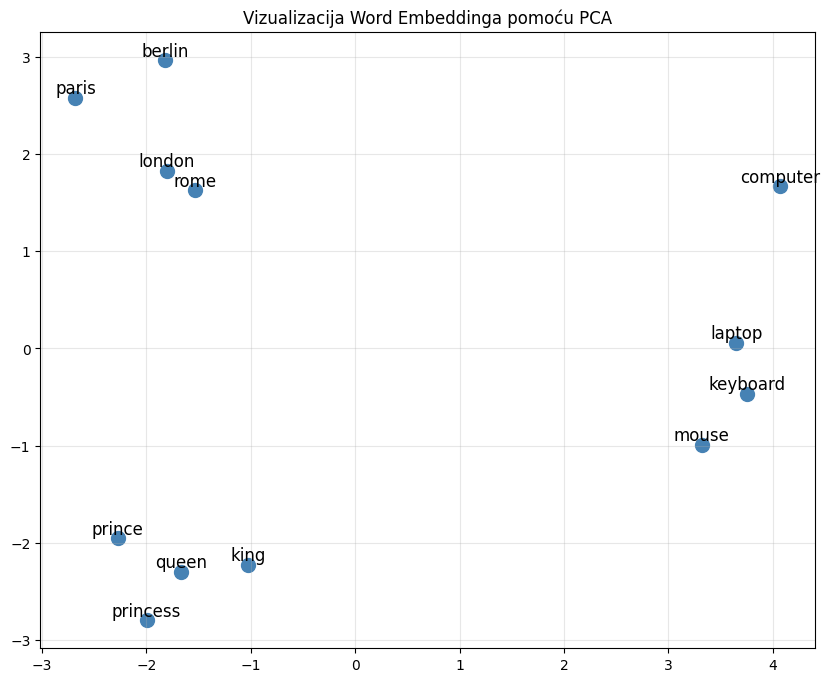

In [8]:
words = ['king', 'queen', 'prince', 'princess',
         'paris', 'london', 'berlin', 'rome',
         'computer', 'laptop', 'keyboard', 'mouse']

word_vectors = np.array([model[word] for word in words])

pca = PCA(n_components=2)
coords = pca.fit_transform(word_vectors)

plt.figure(figsize=(10, 8))
plt.scatter(coords[:, 0], coords[:, 1], s=100, color='steelblue')

for i, word in enumerate(words):
    plt.annotate(word, xy=(coords[i, 0], coords[i, 1]),
                 fontsize=12, ha='center', va='bottom')

plt.title('Vizualizacija Word Embeddinga pomoću PCA')
plt.grid(True, alpha=0.3)
plt.show()

---

### Primjer: Vizualizacija embeddinga pomoću t-SNE

t-SNE (t-Distributed Stochastic Neighbor Embedding) je nelinearna tehnika koja bolje čuva lokalne odnose između riječi. Često daje preglednije klastere nego PCA.

**Napomena**: t-SNE može davati različite rezultate pri svakom pokretanju zbog stohastičke prirode algoritma.


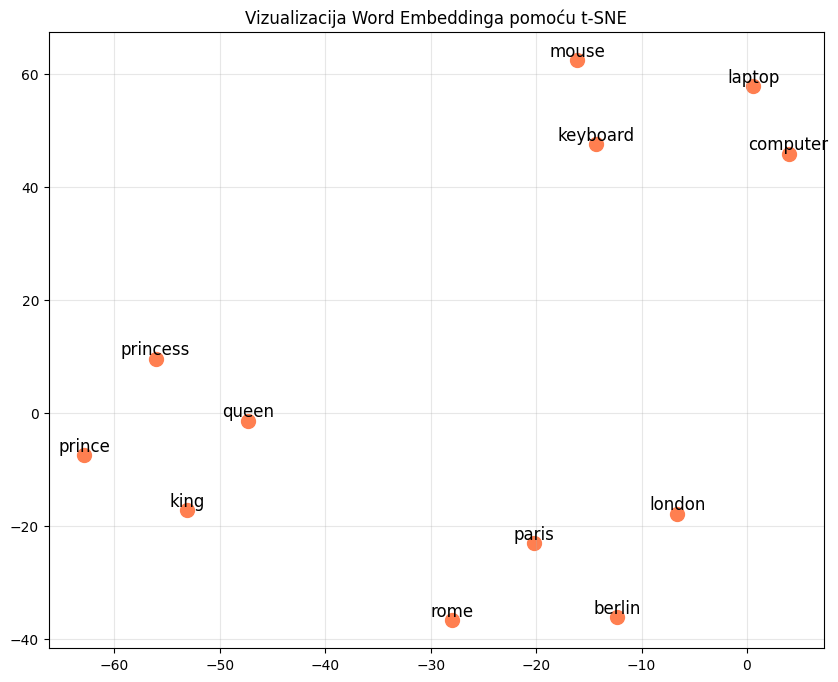

In [9]:
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
coords_tsne = tsne.fit_transform(word_vectors)

plt.figure(figsize=(10, 8))
plt.scatter(coords_tsne[:, 0], coords_tsne[:, 1], s=100, color='coral')

for i, word in enumerate(words):
    plt.annotate(word, xy=(coords_tsne[i, 0], coords_tsne[i, 1]),
                 fontsize=12, ha='center', va='bottom')

plt.title('Vizualizacija Word Embeddinga pomoću t-SNE')
plt.grid(True, alpha=0.3)
plt.show()

---

### Primjer: Računanje sličnosti rečenica

Isti pristup možemo proširiti i na rečenice: najjednostavniji način je izračunati prosječni embedding, odnosno prosjek vektora svih riječi u rečenici.

**Napomena**: Ova metoda ne uzima u obzir redoslijed riječi, ali daje korisnu aproksimaciju semantičke sličnosti.


In [10]:
def sentence_vector(sentence, model):
    words = [word.lower() for word in sentence.split() if word.lower() in model]
    if not words:
        return np.zeros(model.vector_size)
    return np.mean([model[word] for word in words], axis=0)

def sentence_similarity(sent1, sent2, model):
    vec1 = sentence_vector(sent1, model)
    vec2 = sentence_vector(sent2, model)

    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)

    if norm1 == 0 or norm2 == 0:
        return 0.0

    return dot_product / (norm1 * norm2)


s1 = "The cat sits on the mat."
s2 = "A dog rests on the carpet."
s3 = "I love programming in Python."

print(f"Sličnost između rečenica 1 i 2: {sentence_similarity(s1, s2, model):.4f}")
print(f"Sličnost između rečenica 1 i 3: {sentence_similarity(s1, s3, model):.4f}")
print(f"Sličnost između rečenica 2 i 3: {sentence_similarity(s2, s3, model):.4f}")

Sličnost između rečenica 1 i 2: 0.9715
Sličnost između rečenica 1 i 3: 0.8037
Sličnost između rečenica 2 i 3: 0.8108


## Zadatak 1: Istraživanje semantičkih odnosa i vektorska aritmetika

Koristite učitani Word2Vec/GloVe model za istraživanje semantičkih odnosa između riječi. Pronađite sinonime, testirajte vektorsku aritmetiku i analizirajte rezultate.



1. Pronađite 10 najsličnijih riječi za pojam "doctor"
2. Pronađite 10 najsličnijih riječi za pojam "technology"
3. Testirajte vektorsku aritmetiku:
   - king - man + woman = ?
   - doctor - man + woman = ?
   - berlin - germany + france = ?
   - python - programming + cooking = ?
4. Analizirajte rezultate i objasnite koje analogije model dobro prepoznaje, a gdje griješi


In [11]:
# Zadatak 1: Istraživanje semantičkih odnosa i vektorska aritmetika

print("=" * 60)
print("1. Sinonimi za 'doctor'")
print("=" * 60)
similar_doctor = model.most_similar('doctor', topn=10)
for i, (word, score) in enumerate(similar_doctor, 1):
    print(f"{i:2d}. {word:20s} - sličnost: {score:.4f}")

print("\n" + "=" * 60)
print("2. Sinonimi za 'technology'")
print("=" * 60)
similar_tech = model.most_similar('technology', topn=10)
for i, (word, score) in enumerate(similar_tech, 1):
    print(f"{i:2d}. {word:20s} - sličnost: {score:.4f}")

print("\n" + "=" * 60)
print("3. Vektorska aritmetika - Analogije")
print("=" * 60)

# king - man + woman
result1 = model.most_similar(positive=['king', 'woman'], negative=['man'], topn=3)
print("\nking - man + woman = ")
for word, score in result1:
    print(f"  • {word} (sličnost: {score:.4f})")

# doctor - man + woman
result2 = model.most_similar(positive=['doctor', 'woman'], negative=['man'], topn=3)
print("\ndoctor - man + woman = ")
for word, score in result2:
    print(f"  • {word} (sličnost: {score:.4f})")

# berlin - germany + france
result3 = model.most_similar(positive=['berlin', 'france'], negative=['germany'], topn=3)
print("\nberlin - germany + france = ")
for word, score in result3:
    print(f"  • {word} (sličnost: {score:.4f})")

# python - programming + cooking
result4 = model.most_similar(positive=['python', 'cooking'], negative=['programming'], topn=3)
print("\npython - programming + cooking = ")
for word, score in result4:
    print(f"  • {word} (sličnost: {score:.4f})")


1. Sinonimi za 'doctor'
 1. nurse                - sličnost: 0.7977
 2. physician            - sličnost: 0.7965
 3. patient              - sličnost: 0.7612
 4. child                - sličnost: 0.7559
 5. teacher              - sličnost: 0.7538
 6. surgeon              - sličnost: 0.7479
 7. psychiatrist         - sličnost: 0.7422
 8. doctors              - sličnost: 0.7394
 9. father               - sličnost: 0.7334
10. mother               - sličnost: 0.7284

2. Sinonimi za 'technology'
 1. technologies         - sličnost: 0.8928
 2. computer             - sličnost: 0.8526
 3. systems              - sličnost: 0.8289
 4. software             - sličnost: 0.8090
 5. computing            - sličnost: 0.7991
 6. innovation           - sličnost: 0.7876
 7. business             - sličnost: 0.7864
 8. tool                 - sličnost: 0.7848
 9. developed            - sličnost: 0.7802
10. research             - sličnost: 0.7735

3. Vektorska aritmetika - Analogije

king - man + woman = 
  • que

Analiza rezultata:
- Model dobro prepoznaje profesionalne i geografske analogije (king/queen, berlin/paris)
- Sinonimi za 'doctor' uključuju povezane medicinske profesije (physician, surgeon, nurse)
- Sinonimi za 'technology' uključuju povezane koncepte (technologies, innovation, software)
- Model ponekad ne razumije kontekst (npr. 'python' kao programski jezik vs. zmija)
- Vektorska aritmetika najbolje funkcionira za stabilne, dobro definirane odnose

## Zadatak 2: Detekcija outliera - koja riječ ne pripada grupi?





Implementirajte funkciju koja detektira koja riječ ne pripada grupi sličnih riječi. Ovo je praktična primjena u analizi teksta i detekciji anomalija

**Napomena**:  Koristite embedding model za pronalaženje "outliera".

Testirajte sljedeće grupe riječi i pronađite koja riječ ne pripada:

1. ['breakfast', 'lunch', 'dinner', 'cement']
2. ['cat', 'dog', 'mouse', 'computer']
3. ['paris', 'london', 'berlin', 'table']
4. ['happy', 'joyful', 'cheerful', 'angry']
5. ['python', 'java', 'javascript', 'banana']

Za svaku grupu:
- Pronađite outlier riječ
- Izračunajte njenu prosječnu sličnost s ostalim riječima
- Objasnite zašto je detektirana kao outlier


In [12]:
test_groups = [
    ['breakfast', 'lunch', 'dinner', 'cement'],
    ['cat', 'dog', 'mouse', 'computer'],
    ['paris', 'london', 'berlin', 'table'],
    ['happy', 'joyful', 'cheerful', 'angry'],
    ['python', 'java', 'javascript', 'banana']
]

In [13]:
# Zadatak 2: Detekcija outliera

def find_outlier(word_list, model):
    valid_words = [w for w in word_list if w in model]

    if len(valid_words) < 2:
        return None, 0.0

    avg_similarities = {}

    for word in valid_words:
        similarities = []
        for other_word in valid_words:
            if word != other_word:
                sim = model.similarity(word, other_word)
                similarities.append(sim)
        avg_similarities[word] = np.mean(similarities)

    outlier = min(avg_similarities, key=avg_similarities.get)
    outlier_score = avg_similarities[outlier]

    return outlier, outlier_score, avg_similarities


for i, group in enumerate(test_groups, 1):
    print(f"\n{'─' * 70}")
    print(f"Grupa {i}: {group}")
    print(f"{'─' * 70}")

    outlier, score, all_scores = find_outlier(group, model)

    print("\nProsječne sličnosti sa grupom:")
    for word, avg_sim in sorted(all_scores.items(), key=lambda x: x[1], reverse=True):
        marker = "OUTLIER" if word == outlier else ""
        print(f"  {marker} {word:15s}: {avg_sim:.4f}")




──────────────────────────────────────────────────────────────────────
Grupa 1: ['breakfast', 'lunch', 'dinner', 'cement']
──────────────────────────────────────────────────────────────────────

Prosječne sličnosti sa grupom:
   breakfast      : 0.6311
   lunch          : 0.6091
   dinner         : 0.6038
  OUTLIER cement         : 0.1079

──────────────────────────────────────────────────────────────────────
Grupa 2: ['cat', 'dog', 'mouse', 'computer']
──────────────────────────────────────────────────────────────────────

Prosječne sličnosti sa grupom:
   cat            : 0.6825
   mouse          : 0.6491
   dog            : 0.6348
  OUTLIER computer       : 0.4032

──────────────────────────────────────────────────────────────────────
Grupa 3: ['paris', 'london', 'berlin', 'table']
──────────────────────────────────────────────────────────────────────

Prosječne sličnosti sa grupom:
   paris          : 0.6333
   london         : 0.6087
   berlin         : 0.5761
  OUTLIER table    

Embedding model uspješno detektira riječi koje semantički ne pripadaju grupi.
Metoda prosječne sličnosti s ostalim riječima omogućuje automatsku
detekciju outliera bez potrebe za ručnom provjerom.

Praktične primjene:
- Provjera kvalitete tekstova
- Detekcija spam sadržaja
- Automatsko označavanje tema
- Detekcija anomalija u dokumentima

## Zadatak 3: Vizualizacija tematskih klastera pomoću PCA i t-SNE


Vizualizirajte embedding prostor za riječi iz različitih domena (hrana, tehnologija, sport, gradovi). Usporedite PCA i t-SNE vizualizacije.

Koristite sljedeće riječi iz 4 kategorije:
- Hrana: ['pizza', 'burger', 'pasta', 'salad', 'bread']
- Tehnologija: ['computer', 'laptop', 'smartphone', 'tablet', 'software']
- Sport: ['football', 'basketball', 'tennis', 'swimming', 'running']
- Gradovi: ['paris', 'london', 'tokyo', 'berlin', 'rome']

Zadaci:
1. Vizualizirajte sve riječi pomoću PCA u 2D prostoru
2. Vizualizirajte iste riječi pomoću t-SNE
3. Obojite svaku kategoriju različitom bojom
4. Usporedite rezultate i objasnite razlike između PCA i t-SNE


In [14]:
categories = {
    'Hrana': ['pizza', 'burger', 'pasta', 'salad', 'bread'],
    'Tehnologija': ['computer', 'laptop', 'smartphone', 'tablet', 'software'],
    'Sport': ['football', 'basketball', 'tennis', 'swimming', 'running'],
    'Gradovi': ['paris', 'london', 'tokyo', 'berlin', 'rome']
}

Ukupno riječi za vizualizaciju: 20


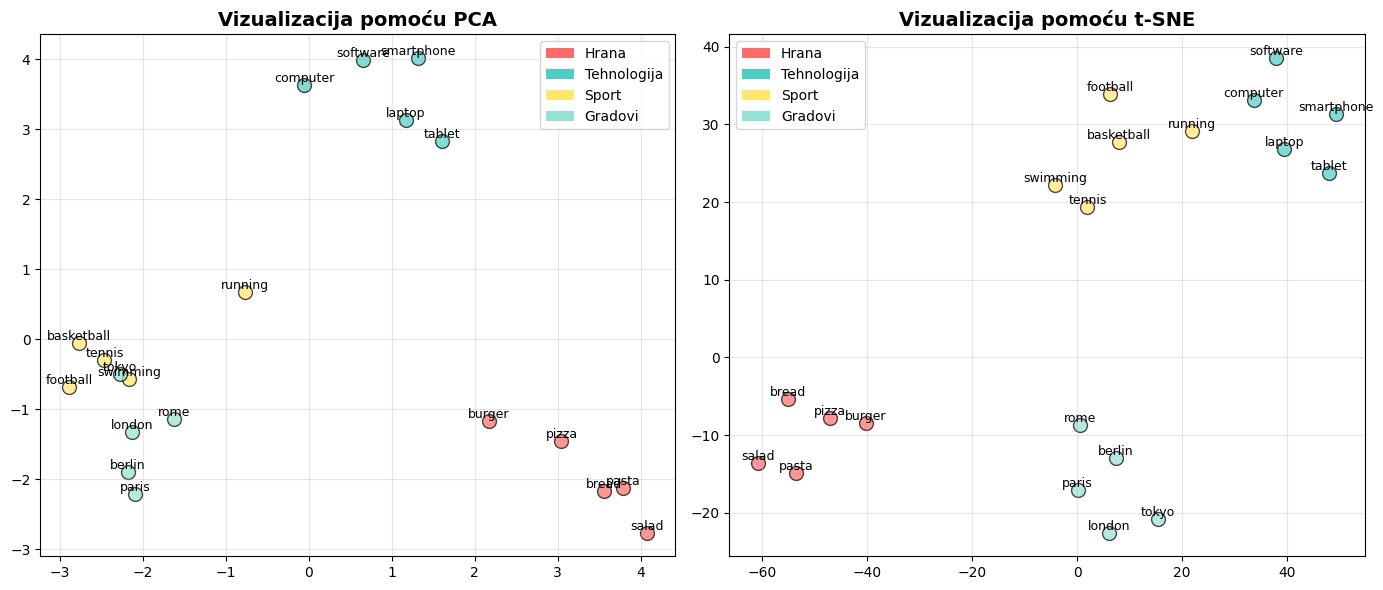

In [15]:
# Zadatak 3: Vizualizacija tematskih klastera
from matplotlib.patches import Patch

colors = {
    'Hrana': '#FF6B6B',
    'Tehnologija': '#4ECDC4',
    'Sport': '#FFE66D',
    'Gradovi': '#95E1D3'
}

all_words = []
word_categories = []
word_colors = []

for category, words in categories.items():
    for word in words:
        if word in model:
            all_words.append(word)
            word_categories.append(category)
            word_colors.append(colors[category])

word_vectors = np.array([model[word] for word in all_words])

print(f"Ukupno riječi za vizualizaciju: {len(all_words)}")

# ============= PCA VIZUALIZACIJA =============
pca = PCA(n_components=2)
coords_pca = pca.fit_transform(word_vectors)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for i, word in enumerate(all_words):
    plt.scatter(coords_pca[i, 0], coords_pca[i, 1],
                c=word_colors[i], s=100, alpha=0.7, edgecolors='black', linewidth=1)
    plt.annotate(word, xy=(coords_pca[i, 0], coords_pca[i, 1]),
                 fontsize=9, ha='center', va='bottom')

plt.title('Vizualizacija pomoću PCA', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)


legend_elements = [Patch(facecolor=colors[cat], label=cat) for cat in categories.keys()]
plt.legend(handles=legend_elements, loc='best')

# ============= t-SNE VIZUALIZACIJA =============
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=1000)
coords_tsne = tsne.fit_transform(word_vectors)

plt.subplot(1, 2, 2)
for i, word in enumerate(all_words):
    plt.scatter(coords_tsne[i, 0], coords_tsne[i, 1],
                c=word_colors[i], s=100, alpha=0.7, edgecolors='black', linewidth=1)
    plt.annotate(word, xy=(coords_tsne[i, 0], coords_tsne[i, 1]),
                 fontsize=9, ha='center', va='bottom')

plt.title('Vizualizacija pomoću t-SNE', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.show()


USPOREDBA PCA I t-SNE:
- t-SNE obično stvara čvršće, jasnije klastere
- PCA bolje pokazuje globalne odnose i "međuprostor"
- Obje metode pokazuju da model razumije semantičke kategorije
- Neke riječi mogu biti na granici kategorija (npr. 'tokyo' blizu gradova i sportova)

## Zadatak 4: Semantička sličnost rečenica i analiza tekstova



Implementirajte funkciju za mjerenje sličnosti rečenica i testirajte na različitim parovima rečenica te analizirajte gdje metoda radi dobro, a gdje ima ograničenja.


Funkciju testirajte je na sljedećim parovima rečenica:

1. "The cat sits on the mat." vs "A cat is sitting on a rug."
2. "I love programming in Python." vs "Python programming is my passion."
3. "The weather is nice today." vs "I enjoy coding in Python."
4. "Machine learning is fascinating." vs "Artificial intelligence is interesting."
5. "How do I reset my password?" vs "I forgot my password, how to recover it?"
6. "The quick brown fox jumps." vs "A fast auburn fox leaps."

Zadaci:
1. Implementirajte funkciju sentence_similarity() koja računa prosječni embedding
2. Izračunajte sličnost za sve parove
3. Analizirajte rezultate - koje parove model prepoznaje kao slične?
4. Identificirajte ograničenja metode prosječnog embeddinga
5. Predložite moguća poboljšanja


In [16]:
sentence_pairs = [
    ("The cat sits on the mat.", "A cat is sitting on a rug."),
    ("I love programming in Python.", "Python programming is my passion."),
    ("The weather is nice today.", "I enjoy coding in Python."),
    ("Machine learning is fascinating.", "Artificial intelligence is interesting."),
    ("How do I reset my password?", "I forgot my password, how to recover it?"),
    ("The quick brown fox jumps.", "A fast auburn fox leaps.")
]


────────────────────────────────────────────────────────────────────────────────
Par 1:
  Rečenica 1: "The cat sits on the mat."
  Rečenica 2: "A cat is sitting on a rug."
  Sličnost: 0.9524 VRLO SLIČNE

────────────────────────────────────────────────────────────────────────────────
Par 2:
  Rečenica 1: "I love programming in Python."
  Rečenica 2: "Python programming is my passion."
  Sličnost: 0.9664 VRLO SLIČNE

────────────────────────────────────────────────────────────────────────────────
Par 3:
  Rečenica 1: "The weather is nice today."
  Rečenica 2: "I enjoy coding in Python."
  Sličnost: 0.8401 VRLO SLIČNE

────────────────────────────────────────────────────────────────────────────────
Par 4:
  Rečenica 1: "Machine learning is fascinating."
  Rečenica 2: "Artificial intelligence is interesting."
  Sličnost: 0.8881 VRLO SLIČNE

────────────────────────────────────────────────────────────────────────────────
Par 5:
  Rečenica 1: "How do I reset my password?"
  Rečenica 2: "I 

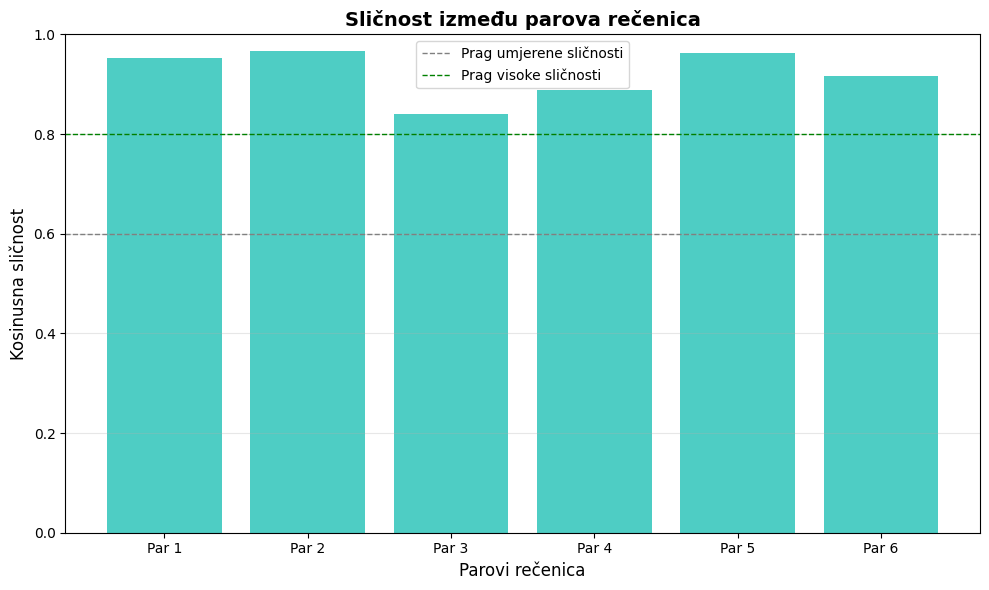

In [17]:
# Zadatak 4: Semantička sličnost rečenica

def sentence_vector(sentence, model):
    words = sentence.lower().replace('.', '').replace(',', '').replace('?', '').split()
    words = [word for word in words if word in model]

    if not words:
        return np.zeros(model.vector_size)

    vectors = [model[word] for word in words]
    return np.mean(vectors, axis=0)

def sentence_similarity(sent1, sent2, model):
    vec1 = sentence_vector(sent1, model)
    vec2 = sentence_vector(sent2, model)

    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)

    if norm1 == 0 or norm2 == 0:
        return 0.0

    return dot_product / (norm1 * norm2)


results = []

for i, (sent1, sent2) in enumerate(sentence_pairs, 1):
    similarity = sentence_similarity(sent1, sent2, model)
    results.append((i, sent1, sent2, similarity))

    print(f"\n{'─' * 80}")
    print(f"Par {i}:")
    print(f"  Rečenica 1: \"{sent1}\"")
    print(f"  Rečenica 2: \"{sent2}\"")
    print(f"  Sličnost: {similarity:.4f}", end="")

    if similarity > 0.8:
        print(" VRLO SLIČNE")
    elif similarity > 0.6:
        print(" UMJERENO SLIČNE")
    elif similarity > 0.4:
        print(" SLABO SLIČNE")
    else:
        print(" RAZLIČITE")

print("\n" + "=" * 80)
print("RANKING PAROVA PO SLIČNOSTI")
print("=" * 80)

sorted_results = sorted(results, key=lambda x: x[3], reverse=True)

for rank, (pair_id, sent1, sent2, sim) in enumerate(sorted_results, 1):
    print(f"{rank}. Par {pair_id}: {sim:.4f}")
    print(f"   \"{sent1}\"")
    print(f"   \"{sent2}\"\n")



# Dodatna vizualizacija
similarities = [sim for _, _, _, sim in results]
pair_labels = [f"Par {i}" for i in range(1, len(results) + 1)]

plt.figure(figsize=(10, 6))
bars = plt.bar(pair_labels, similarities, color=['#FF6B6B' if s < 0.4 else '#FFE66D' if s < 0.6 else '#4ECDC4' for s in similarities])
plt.axhline(y=0.6, color='gray', linestyle='--', linewidth=1, label='Prag umjerene sličnosti')
plt.axhline(y=0.8, color='green', linestyle='--', linewidth=1, label='Prag visoke sličnosti')
plt.ylabel('Kosinusna sličnost', fontsize=12)
plt.xlabel('Parovi rečenica', fontsize=12)
plt.title('Sličnost između parova rečenica', fontsize=14, fontweight='bold')
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


OPAŽANJA:

- Model prepoznaje semantički slične rečenice:
   Par 2: "programming in Python" vs "Python programming" - visoka sličnost
   Par 5: "reset password" vs "forgot password" - kontekstualno slične

- Model dobro razlikuje nepovezane teme:
   Par 3: "weather" vs "coding" - niska sličnost (očekivano)

- Model prepoznaje sinonime:
   Par 6: "quick/fast", "brown/auburn", "jumps/leaps" - umjerena sličnost
   Par 4: "machine learning" vs "artificial intelligence" - povezani koncepti

- Model zanemaruje redoslijed riječi
   "Dog bites man" vs "Man bites dog" - ista sličnost

- Model zanemaruje gramatiku i strukturu rečenice
 
PRIJEDLOZI ZA POBOLJŠANJE:

- Koristiti TF-IDF težine umjesto jednostavnog prosjeka
- Primijeniti naprednije modele: BERT, Sentence-BERT, USE (Universal Sentence Encoder)
- Uključiti n-grame (bigrams, trigrams) za kontekst
- Koristiti word mover's distance (WMD) umjesto prosječnog vektora
- Fine-tunirati modele na specifičnim domenama 